In [1]:
import os
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import cv2

#data path 수정
os.chdir("C:\\Users\\Owner2\\Desktop\\G팔로미_vuno")
os.getcwd()

'C:\\Users\\Owner2\\Desktop\\G팔로미_vuno'

In [2]:
X=np.load('data_X_origin.npy')
y=np.load('data_y.npy')

In [3]:
#train, validation set 분리
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.3)

In [4]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    ##featurewise_center=True,
    #featurewise_std_normalization=True, 
    rotation_range=25.0,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True) #수평방향 뒤집기

datagen.fit(X_train)

dgf=datagen.flow(X_train,y_train,batch_size=64)

Using TensorFlow backend.


In [13]:
from keras import layers, models
from keras.applications import VGG16
from keras import Input
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, initializers, regularizers, metrics
from keras.callbacks import ModelCheckpoint
import os
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
 


pre_trained_vgg = VGG16(weights=None, include_top=False, input_shape=(224, 224, 3))
pre_trained_vgg.trainable = True
pre_trained_vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [14]:
additional_model = models.Sequential()
additional_model.add(pre_trained_vgg)
additional_model.add(layers.Flatten())
additional_model.add(layers.Dense(4096, activation='relu'))
additional_model.add(layers.Dense(2048, activation='relu'))
additional_model.add(layers.Dense(1024, activation='relu'))
additional_model.add(layers.Dense(4, activation='softmax'))

additional_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 4096)              102764544 
_________________________________________________________________
dense_6 (Dense)              (None, 2048)              8390656   
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 4100      
Total params: 127,972,164
Trainable params: 127,972,164
Non-trainable params: 0
______________________________________________________________

In [15]:
# checkpoint = ModelCheckpoint(filepath='My_VGG_{epoch:03d}_{val_loss:.7f}.hdf5',monitor='loss', mode='min', save_best_only=True)
checkpoint = ModelCheckpoint(filepath='vgg16_trainable_1.hdf5', 
            monitor='loss', 
            mode='min', 
            save_best_only=True)

In [16]:
from keras import backend as K
import tensorflow as tf

def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

def recall(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Negative) = 실제 값이 1(Positive) 전체
    count_true_positive_false_negative = K.sum(y_target_yn)

    # Recall =  (True Positive) / (True Positive + False Negative)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())

    # return a single tensor value
    return recall


def precision(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Positive) = 예측 값이 1(Positive) 전체
    count_true_positive_false_positive = K.sum(y_pred_yn)

    # Precision = (True Positive) / (True Positive + False Positive)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())

    # return a single tensor value
    return precision


def f1score(y_target, y_pred):
    _recall = recall(y_target, y_pred)
    _precision = precision(y_target, y_pred)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    _f1score = ( 2 * _recall * _precision) / (_recall + _precision+ K.epsilon())
    
    # return a single tensor value
    return _f1score

In [17]:
additional_model.compile(loss='categorical_crossentropy',
                         optimizer=optimizers.RMSprop(lr=1e-7), 
                         metrics=['acc', auc, precision, recall, f1score])

In [18]:
X.shape

(2861, 224, 224, 3)

In [19]:
# history1=myvgg.fit(X,y,batch_size=32,
#                   epochs=100,
#                   validation_split=0.3,
#                   callbacks=[checkpoint])

In [20]:
history = additional_model.fit_generator(dgf, 
            steps_per_epoch=150, 
            epochs=100, 
            validation_data=(X_val,y_val), 
            validation_steps=16, 
            callbacks=[checkpoint])

Epoch 1/100
150/150 [==============================] - 84s 561ms/step - loss: 9.8885 - acc: 0.2614 - auc: 0.4759 - precision: 0.2614 - recall: 0.2614 - f1score: 0.2614 - val_loss: 9.7093 - val_acc: 0.3190 - val_auc: 0.4819 - val_precision: 0.3190 - val_recall: 0.3190 - val_f1score: 0.3190
Epoch 2/100
150/150 [==============================] - 80s 535ms/step - loss: 5.6698 - acc: 0.3532 - auc: 0.5044 - precision: 0.3578 - recall: 0.3396 - f1score: 0.3483 - val_loss: 4.9466 - val_acc: 0.3981 - val_auc: 0.5260 - val_precision: 0.4063 - val_recall: 0.3795 - val_f1score: 0.3923
Epoch 3/100
150/150 [==============================] - 81s 539ms/step - loss: 5.0062 - acc: 0.3770 - auc: 0.5397 - precision: 0.3812 - recall: 0.3567 - f1score: 0.3684 - val_loss: 5.0576 - val_acc: 0.4517 - val_auc: 0.5514 - val_precision: 0.4519 - val_recall: 0.4470 - val_f1score: 0.4495
Epoch 4/100
150/150 [==============================] - 80s 536ms/step - loss: 4.8657 - acc: 0.3882 - auc: 0.5600 - precision: 0.39

150/150 [==============================] - 80s 536ms/step - loss: 1.4418 - acc: 0.4679 - auc: 0.6766 - precision: 0.4986 - recall: 0.4072 - f1score: 0.4475 - val_loss: 1.2622 - val_acc: 0.5041 - val_auc: 0.6776 - val_precision: 0.5381 - val_recall: 0.4354 - val_f1score: 0.4810
Epoch 30/100
150/150 [==============================] - 80s 534ms/step - loss: 1.4480 - acc: 0.4635 - auc: 0.6786 - precision: 0.4977 - recall: 0.4011 - f1score: 0.4434 - val_loss: 1.3402 - val_acc: 0.4785 - val_auc: 0.6794 - val_precision: 0.5112 - val_recall: 0.4086 - val_f1score: 0.4539
Epoch 31/100
150/150 [==============================] - 80s 535ms/step - loss: 1.4577 - acc: 0.4697 - auc: 0.6802 - precision: 0.4974 - recall: 0.4017 - f1score: 0.4436 - val_loss: 1.5074 - val_acc: 0.4633 - val_auc: 0.6809 - val_precision: 0.4879 - val_recall: 0.4191 - val_f1score: 0.4505
Epoch 32/100
150/150 [==============================] - 81s 537ms/step - loss: 1.4272 - acc: 0.4621 - auc: 0.6817 - precision: 0.4959 - reca

150/150 [==============================] - 80s 534ms/step - loss: 1.3153 - acc: 0.4724 - auc: 0.7100 - precision: 0.5127 - recall: 0.4036 - f1score: 0.4509 - val_loss: 1.2454 - val_acc: 0.4773 - val_auc: 0.7104 - val_precision: 0.5155 - val_recall: 0.4086 - val_f1score: 0.4557
Epoch 58/100
150/150 [==============================] - 80s 533ms/step - loss: 1.2876 - acc: 0.4790 - auc: 0.7108 - precision: 0.5178 - recall: 0.4060 - f1score: 0.4542 - val_loss: 1.4663 - val_acc: 0.4552 - val_auc: 0.7111 - val_precision: 0.4728 - val_recall: 0.4098 - val_f1score: 0.4386
Epoch 59/100
150/150 [==============================] - 80s 534ms/step - loss: 1.3160 - acc: 0.4746 - auc: 0.7114 - precision: 0.5143 - recall: 0.4040 - f1score: 0.4514 - val_loss: 1.3191 - val_acc: 0.5204 - val_auc: 0.7118 - val_precision: 0.5432 - val_recall: 0.4715 - val_f1score: 0.5046
Epoch 60/100
150/150 [==============================] - 80s 533ms/step - loss: 1.2723 - acc: 0.4993 - auc: 0.7122 - precision: 0.5374 - reca

150/150 [==============================] - 80s 532ms/step - loss: 1.2218 - acc: 0.4983 - auc: 0.7273 - precision: 0.5430 - recall: 0.4222 - f1score: 0.4741 - val_loss: 1.3624 - val_acc: 0.4598 - val_auc: 0.7276 - val_precision: 0.4945 - val_recall: 0.4028 - val_f1score: 0.4438
Epoch 86/100
150/150 [==============================] - 80s 536ms/step - loss: 1.2251 - acc: 0.5028 - auc: 0.7278 - precision: 0.5443 - recall: 0.4233 - f1score: 0.4752 - val_loss: 1.3615 - val_acc: 0.4715 - val_auc: 0.7280 - val_precision: 0.4984 - val_recall: 0.4249 - val_f1score: 0.4583
Epoch 87/100
150/150 [==============================] - 80s 535ms/step - loss: 1.2329 - acc: 0.4969 - auc: 0.7282 - precision: 0.5373 - recall: 0.4140 - f1score: 0.4667 - val_loss: 1.2158 - val_acc: 0.4808 - val_auc: 0.7285 - val_precision: 0.5225 - val_recall: 0.4098 - val_f1score: 0.4589
Epoch 88/100
150/150 [==============================] - 80s 535ms/step - loss: 1.2014 - acc: 0.4988 - auc: 0.7287 - precision: 0.5480 - reca

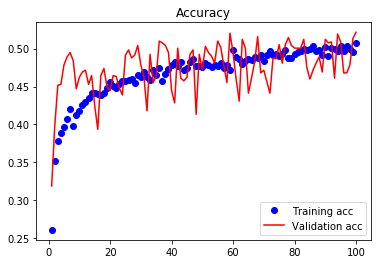

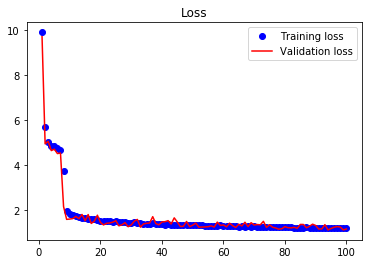

In [21]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(1, len(acc) + 1)
 
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Accuracy')
plt.legend()
plt.figure()
 
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Loss')
plt.legend()
 
plt.show()

In [23]:
X_test=np.load('X_test.npy')
y_test=np.load('y_test.npy')

In [24]:
_loss, _acc, _auc, _precision, _recall, _f1score = additional_model.evaluate(X_test, y_test, batch_size=64)
print('loss: {:.3f}, accuracy: {:.3f}, auc: {:.3f}, precision: {:.3f}, recall: {:.3f}, f1score: {:.3f}'.format(_loss, _acc, _auc, _precision, _recall, _f1score))

704/704 [==============================] - 2s 3ms/step
loss: 6.455, accuracy: 0.264, auc: 0.734, precision: 0.262, recall: 0.259, f1score: 0.260


In [25]:
_loss, _acc, _auc, _precision, _recall, _f1score = additional_model.evaluate(X_val, y_val, batch_size=64)
print('loss: {:.3f}, accuracy: {:.3f}, auc: {:.3f}, precision: {:.3f}, recall: {:.3f}, f1score: {:.3f}'.format(_loss, _acc, _auc, _precision, _recall, _f1score))

859/859 [==============================] - 2s 3ms/step
loss: 1.162, accuracy: 0.522, auc: 0.734, precision: 0.551, recall: 0.461, f1score: 0.502


In [ ]:
myvgg.save('VGG16_Aug_1.h5')